#Kaggle API

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:37<00:00, 39.6MB/s]
100% 1.14G/1.14G [00:37<00:00, 32.8MB/s]


In [ ]:
import zipfile

input_file = "/content/pneumonia-xray-images.zip"
Directory_target = "/content/dataset/cnn/pneumonia_revamped"

file_input = zipfile.ZipFile(input_file)
file_input.extractall(Directory_target)

# 1 Set up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Define Constants

In [ ]:
path_train = '/content/dataset/cnn/pneumonia_revamped/train'
path_test = '/content/dataset/cnn/pneumonia_revamped/test'
path_valid = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [ ]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

gen_image = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

gen_data_test = ImageDataGenerator(rescale = 1./255)


#Loading the augmented image data
aug_train = gen_image.flow_from_directory(
    path_train,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

aug_test = gen_data_test.flow_from_directory(
      path_train,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
aug_valid = gen_data_test.flow_from_directory(
      path_valid,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


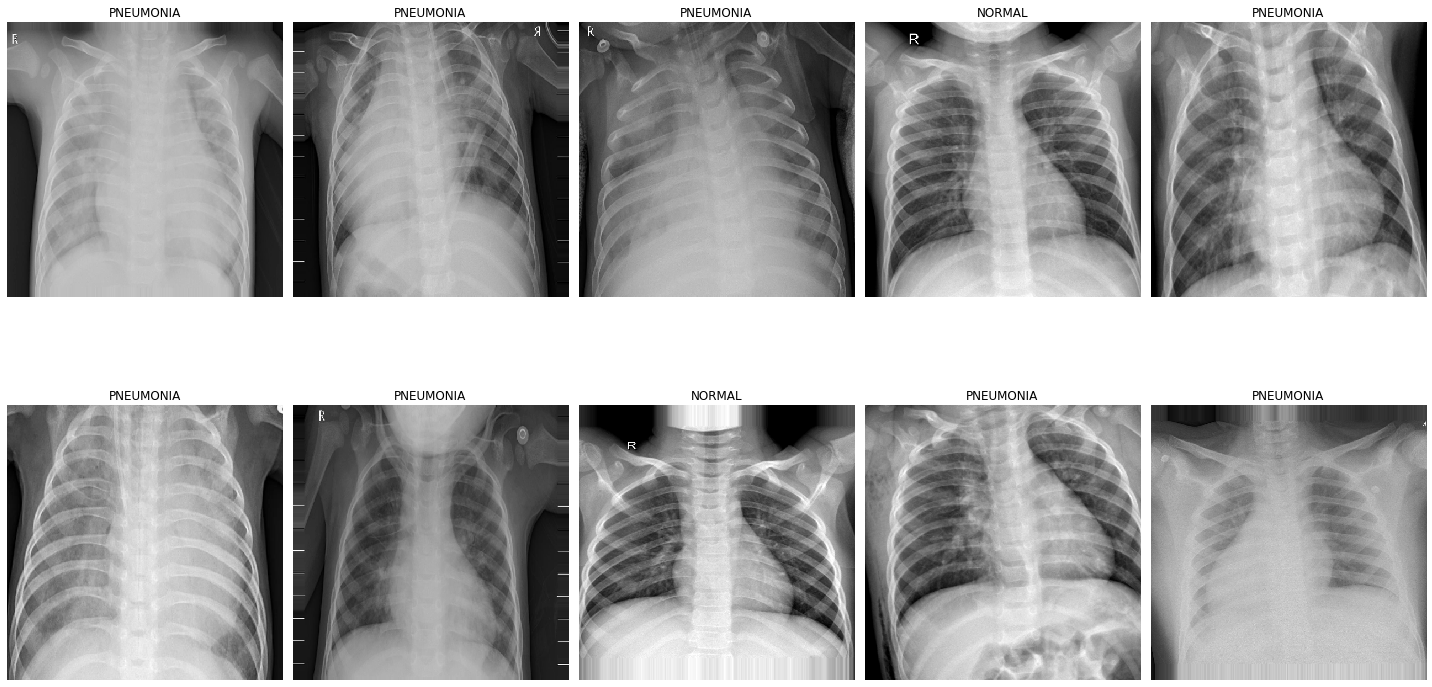

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in aug_train:
        image_train = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image_train),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

# 3 Tensorflow - Keras

In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [ ]:
# let's build the CNN model

cnn_model = Sequential() #initializing the CNN

cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #Convolution
cnn_model.add(MaxPooling2D(pool_size = (2, 2))) #Pooling

cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #Second convolution layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2))) #pooling

cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #third layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #fourth layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #fifth layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Flatten()) #flattening

#full connection
cnn_model.add(Dense(activation = 'relu', units = 128))
cnn_model.add(Dense(activation = 'relu', units = 64))
cnn_model.add(Dense(activation = 'sigmoid', units = 1))

#Compiling the CNN
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

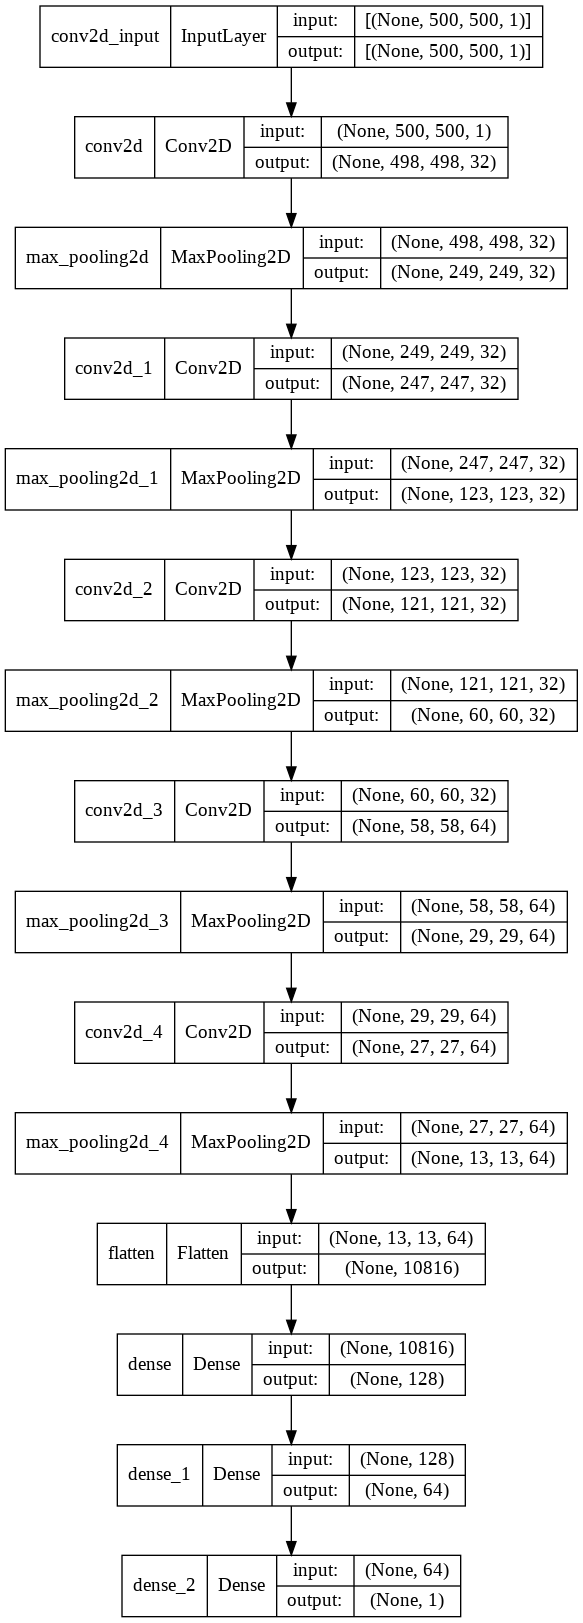

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 3.2 Fit Model

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

list_callbacks = [early_stop, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights_class = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train.classes),
                                        y = aug_train.classes                                                    
                                    )
cl_weights = dict(zip(np.unique(aug_train.classes), weights_class)),
print(cl_weights)


({0: 1.9371534195933457, 1: 0.6739549839228296},)


In [ ]:
cl_weights = {0: 1.9371534195933457, 1: 0.6739549839228296}

In [ ]:
cnn_model.fit(aug_train,epochs=25, validation_data=aug_valid, class_weight=cl_weights, callbacks=list_callbacks)

Epoch 1/25
262/262 [==============================] - 146s 513ms/step - loss: 0.4277 - accuracy: 0.7581 - val_loss: 0.1959 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 135s 516ms/step - loss: 0.2321 - accuracy: 0.9141 - val_loss: 0.3307 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 136s 517ms/step - loss: 0.2056 - accuracy: 0.9151 - val_loss: 0.1817 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 135s 515ms/step - loss: 0.2026 - accuracy: 0.9229 - val_loss: 0.1598 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - 135s 513ms/step - loss: 0.1779 - accuracy: 0.9320 - val_loss: 0.1638 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 6/25
262/262 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9342
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [====================

##3.3 Evaluation

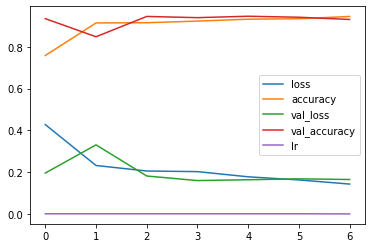

In [ ]:
pd.DataFrame(cnn_model.history.history).plot()

In [ ]:
acc_test = cnn_model.evaluate(aug_test)
print('The testing accuracy is :',acc_test[1]*100, '%')

262/262 [==============================] - 49s 188ms/step - loss: 0.1630 - accuracy: 0.9418
The testing accuracy is : 94.17939186096191 %


In [ ]:
predictions = cnn_model.predict(aug_test,verbose=1)

262/262 [==============================] - 49s 186ms/step


In [ ]:
predic = predictions.copy()
predic[predic <= 0.5] = 0
predic[predic > 0.5] = 1

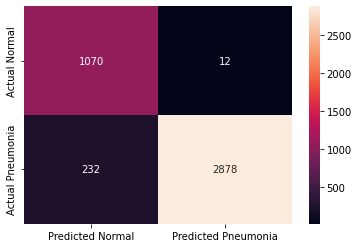

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

confusion_m = pd.DataFrame(data=confusion_matrix(aug_test.classes, predic, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(confusion_m,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=aug_test.classes, y_pred=predic,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.82      0.99      0.90      1082
   PNEUMONIA       1.00      0.93      0.96      3110

    accuracy                           0.94      4192
   macro avg       0.91      0.96      0.93      4192
weighted avg       0.95      0.94      0.94      4192



In [ ]:
aug_test.reset()
cx=np.concatenate([aug_test.next()[0] for i in range(aug_test.__len__())])
cy=np.concatenate([aug_test.next()[1] for i in range(aug_test.__len__())])
print(cx.shape)
print(cy.shape)

(4192, 500, 500, 1)
(4192,)


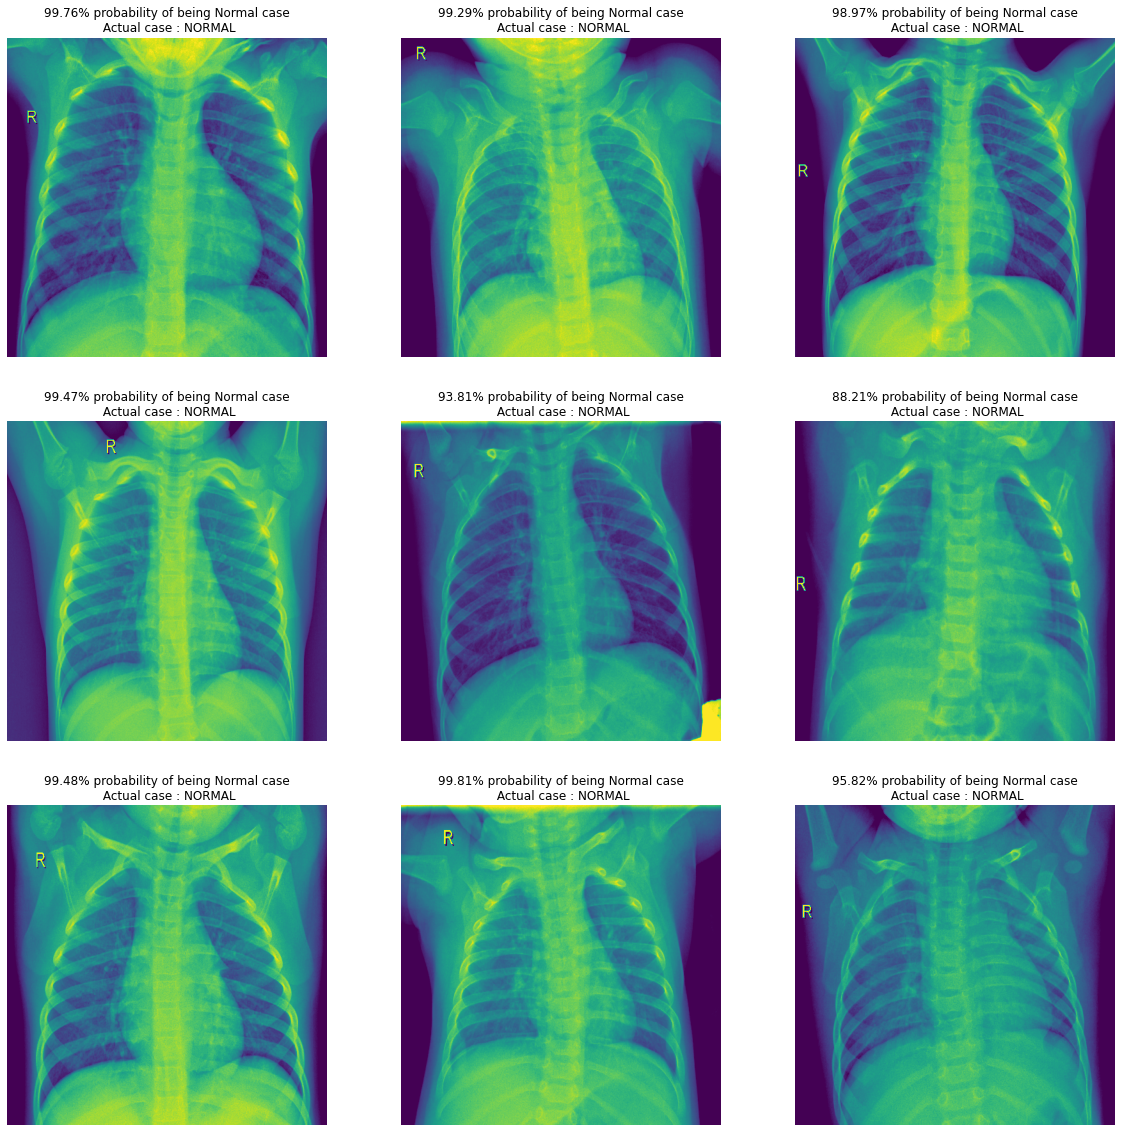

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if predictions[i, 0] >= 0.5: 
      pred_out = ('{:.2%} probability of being Pneumonia case'.format(predictions[i][0]))
      
      
  else: 
      pred_out = ('{:.2%} probability of being Normal case'.format(1-predictions[i][0]))
      
      

  plt.title(pred_out+"\n Actual case : "+ dic.get(cy[i]))    
  plt.imshow(np.squeeze(cx[i]))
  plt.axis('off')
plt.show()

#MODEL 2


In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Initialising the CNN
cnn2= Sequential()

# Step 1 - Convolution
cnn2.add(Conv2D(32, (3, 3), input_shape = (img_width, img_height, 1), activation = 'relu'))
cnn2.add(MaxPooling2D(pool_size = (2, 2)))
cnn2.add(Dropout(0.2))
# Adding a second convolutional layer
cnn2.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn2.add(MaxPooling2D(pool_size = (2, 2)))
cnn2.add(Dropout(0.2))
# Adding a third convolutional layer
cnn2.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn2.add(MaxPooling2D(pool_size = (2, 2)))
cnn2.add(Dropout(0.2))
# Step 3 - Flattening
cnn2.add(Flatten())

# Step 4 - Full connection
cnn2.add(Dense(units = 128, activation = 'relu'))
cnn2.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
optim=tensorflow.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
cnn2.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 249, 249, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 123, 123, 32)     

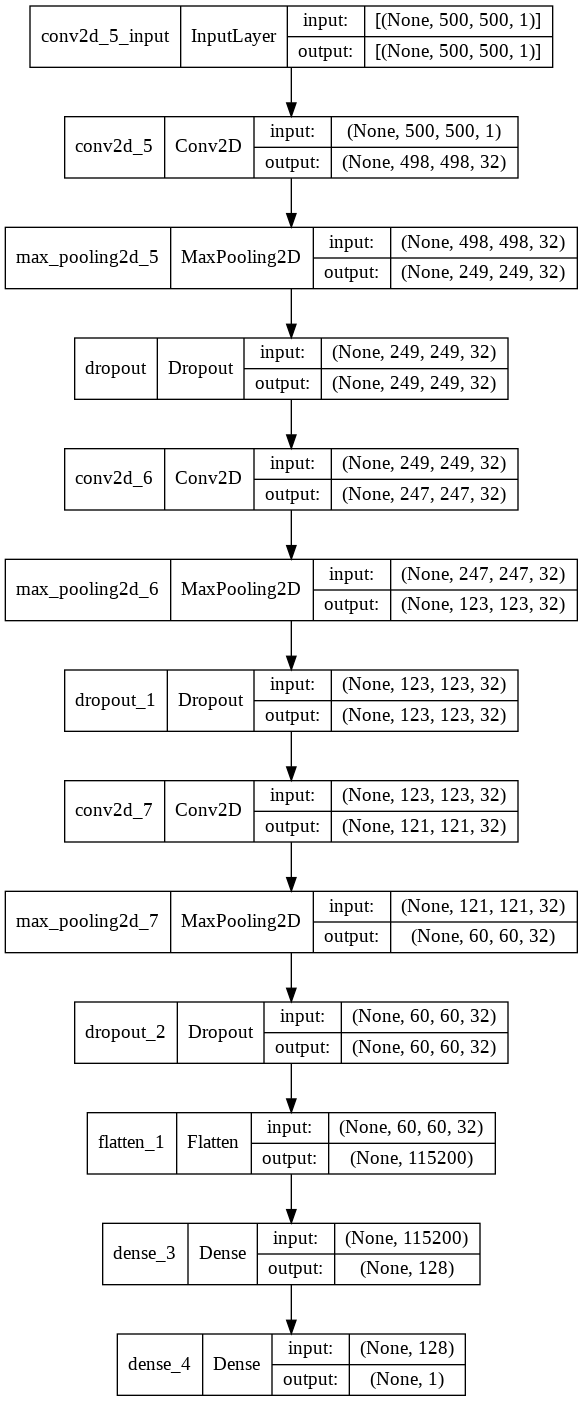

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn2,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

##Fit Model 2

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [early]

In [ ]:
cnn2.fit(aug_train,epochs=20, validation_data=aug_valid, class_weight=cl_weights, callbacks=callbacks_list)

Epoch 1/20
262/262 [==============================] - 150s 569ms/step - loss: 0.8043 - accuracy: 0.7677 - val_loss: 0.3639 - val_accuracy: 0.8077
Epoch 2/20
262/262 [==============================] - 154s 588ms/step - loss: 0.2855 - accuracy: 0.8917 - val_loss: 0.1796 - val_accuracy: 0.9433
Epoch 3/20
262/262 [==============================] - 149s 569ms/step - loss: 0.2445 - accuracy: 0.9129 - val_loss: 0.2145 - val_accuracy: 0.9423
Epoch 4/20
262/262 [==============================] - 152s 579ms/step - loss: 0.2661 - accuracy: 0.9094 - val_loss: 0.2391 - val_accuracy: 0.9183
Epoch 5/20
262/262 [==============================] - 149s 568ms/step - loss: 0.2395 - accuracy: 0.9179 - val_loss: 0.1648 - val_accuracy: 0.9433
Epoch 6/20
262/262 [==============================] - 147s 563ms/step - loss: 0.2183 - accuracy: 0.9251 - val_loss: 0.1492 - val_accuracy: 0.9471
Epoch 7/20
262/262 [==============================] - 146s 558ms/step - loss: 0.2632 - accuracy: 0.9210 - val_loss: 0.1656 -

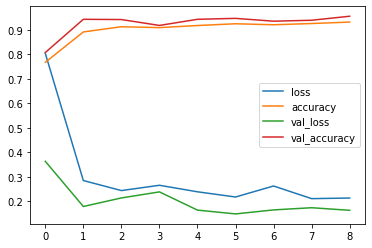

In [ ]:
pd.DataFrame(cnn2.history.history).plot()

In [ ]:
test1_accu = cnn2.evaluate(aug_test)
print('The testing accuracy is :',test1_accu[1]*100, '%')

262/262 [==============================] - 56s 213ms/step - loss: 0.1650 - accuracy: 0.9513
The testing accuracy is : 95.13359069824219 %


In [ ]:
preds1 = cnn2.predict(aug_test,verbose=1)

262/262 [==============================] - 53s 203ms/step


In [ ]:
predictions_preds = preds1.copy()
predictions_preds[predictions_preds <= 0.5] = 0
predictions_preds[predictions_preds > 0.5] = 1

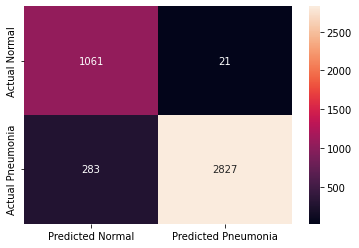

In [ ]:
confusion_m1 = pd.DataFrame(data=confusion_matrix(aug_test.classes, predictions_preds, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(confusion_m1,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=aug_test.classes, y_pred=predictions_preds,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.79      0.98      0.87      1082
   PNEUMONIA       0.99      0.91      0.95      3110

    accuracy                           0.93      4192
   macro avg       0.89      0.94      0.91      4192
weighted avg       0.94      0.93      0.93      4192



#Model 3

In [ ]:
# let's build the CNN model

cnn_model3 = Sequential() #initializing the CNN

cnn_model3.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #Convolution
cnn_model3.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


cnn_model3.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #Second convolution layer
cnn_model3.add(MaxPooling2D(pool_size = (2, 2))) #pooling
cnn_model3.add(Dropout(0.2))

cnn_model3.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #third layer
cnn_model3.add(MaxPooling2D(pool_size = (2, 2)))


cnn_model3.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #fourth layer
cnn_model3.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model3.add(Dropout(0.2))

cnn_model3.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #fifth layer
cnn_model3.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model3.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1))) #sixth layer
cnn_model3.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model3.add(Dropout(0.2))

cnn_model3.add(Flatten()) #flattening

#Dense layer 1
cnn_model3.add(Dense(activation = 'relu', units = 128))
cnn_model3.add(Dropout(0.3))
cnn_model3.add(BatchNormalization())

#Dense layer 2
cnn_model3.add(Dense(activation = 'relu', units = 64))
cnn_model3.add(Dropout(0.3))
cnn_model3.add(BatchNormalization())

#Dense layer 3
cnn_model3.add(Dense(activation = 'sigmoid', units = 1))

#Compiling the CNN
cnn_model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 123, 123, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 121, 121, 32)     

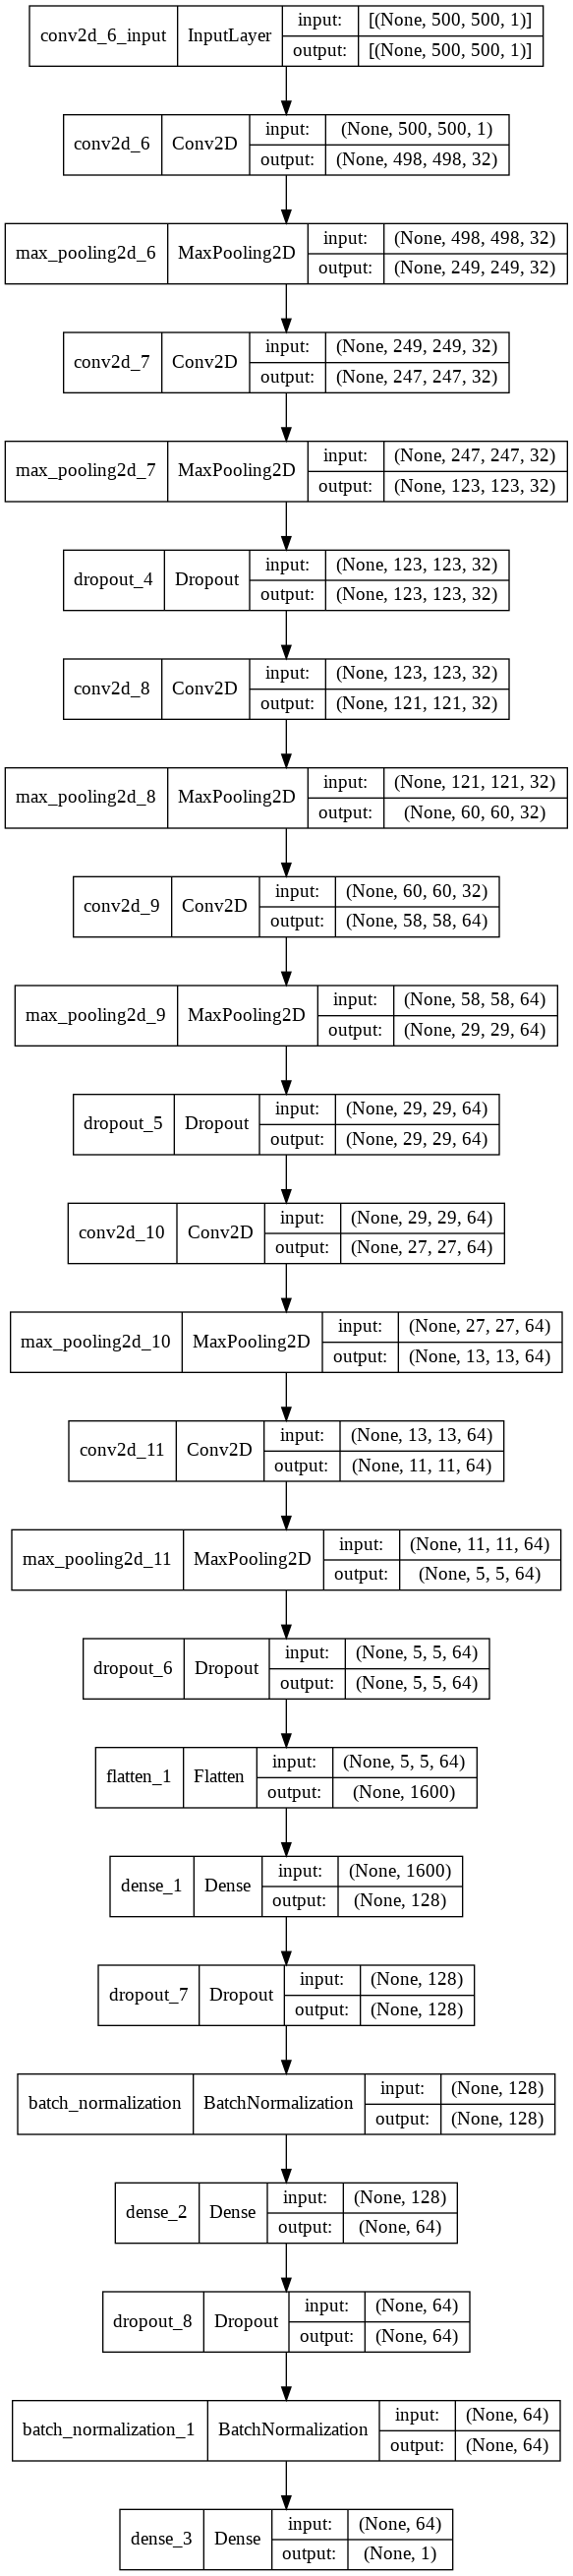

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_model3,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [early]

In [ ]:
cnn_model3.fit(aug_train,epochs=20, validation_data=aug_valid, class_weight=cl_weights, callbacks=callbacks_list)

Epoch 1/20
262/262 [==============================] - 150s 528ms/step - loss: 0.6819 - accuracy: 0.6047 - val_loss: 0.4177 - val_accuracy: 0.8394
Epoch 2/20
262/262 [==============================] - 137s 522ms/step - loss: 0.3904 - accuracy: 0.8318 - val_loss: 0.2880 - val_accuracy: 0.9000
Epoch 3/20
262/262 [==============================] - 136s 520ms/step - loss: 0.3340 - accuracy: 0.8631 - val_loss: 0.6952 - val_accuracy: 0.6798
Epoch 4/20
262/262 [==============================] - 137s 521ms/step - loss: 0.2890 - accuracy: 0.8798 - val_loss: 0.2331 - val_accuracy: 0.9125
Epoch 5/20
262/262 [==============================] - 136s 519ms/step - loss: 0.2793 - accuracy: 0.8810 - val_loss: 0.2725 - val_accuracy: 0.8788
Epoch 6/20
262/262 [==============================] - 137s 521ms/step - loss: 0.2678 - accuracy: 0.8896 - val_loss: 0.1933 - val_accuracy: 0.9385
Epoch 7/20
262/262 [==============================] - 136s 520ms/step - loss: 0.2522 - accuracy: 0.8943 - val_loss: 0.1848 -

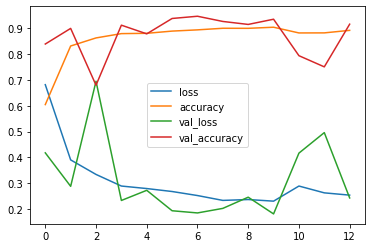

In [ ]:
pd.DataFrame(cnn_model3.history.history).plot()

In [ ]:
test_acc1 = cnn_model3.evaluate(aug_test)
print('The testing accuracy is :',test_acc1[1]*100, '%')

262/262 [==============================] - 50s 189ms/step - loss: 0.1993 - accuracy: 0.9249
The testing accuracy is : 92.48568415641785 %


In [24]:
preds2 = cnn_model3.predict(aug_test,verbose=1)

262/262 [==============================] - 49s 184ms/step


In [25]:
predictions_preds1 = preds2.copy()
predictions_preds1[predictions_preds1 <= 0.5] = 0
predictions_preds1[predictions_preds1 > 0.5] = 1

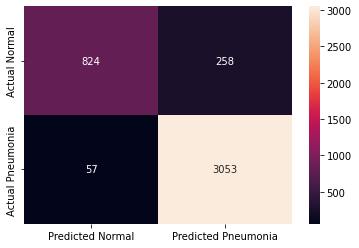

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_m2 = pd.DataFrame(data=confusion_matrix(aug_test.classes, predictions_preds1, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(confusion_m2,annot=True,fmt="d")

In [28]:
print(classification_report(y_true=aug_test.classes, y_pred=predictions_preds1,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.94      0.76      0.84      1082
   PNEUMONIA       0.92      0.98      0.95      3110

    accuracy                           0.92      4192
   macro avg       0.93      0.87      0.90      4192
weighted avg       0.93      0.92      0.92      4192

